In [1]:
import os
import subprocess

# Function to check if a package is installed
def is_package_installed(package_name):
    try:
        subprocess.check_call([package_name, '--version'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        return True
    except (subprocess.CalledProcessError, FileNotFoundError):
        return False

# Function to check if a conda environment exists
def is_conda_env_installed(env_name):
    try:
        output = subprocess.check_output(['conda', 'env', 'list'], stderr=subprocess.STDOUT).decode()
        return env_name in output
    except subprocess.CalledProcessError:
        return False

# Install condacolab if conda is not available
if not is_package_installed('conda'):
    subprocess.check_call(['pip', 'install', '-q', 'condacolab'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    import condacolab
    condacolab.install()

# Check again if conda is installed after condacolab installation
if is_package_installed('conda'):
    # Install pymeep using mamba if not already installed
    try:
        import meep as mp
    except ImportError:
        subprocess.check_call(['mamba', 'install', '-c', 'conda-forge', 'pymeep', '-y'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # Create the parallel Meep environment if it doesn't exist
    if not is_conda_env_installed('pmp'):
        subprocess.check_call(['mamba', 'create', '-n', 'pmp', '-c', 'conda-forge', 'pymeep=*=mpi_mpich_*', '-y'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # Check if nlopt is installed, install if not
    try:
        import nlopt
    except ImportError:
        subprocess.check_call(['pip', 'install', '-q', 'nlopt'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # Check if everything is installed correctly
    subprocess.check_call(['conda', 'list'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
else:
    raise EnvironmentError("Conda installation failed")


⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
resolution = 10
n_r = 1.45  # refractive index of the medium
lambda_min = 0.4
lambda_max = 0.8
f_min = 1 / lambda_max
f_max = 1 / lambda_min
fcen = (f_min + f_max) / 2  # center frequency
df = f_max - f_min  # frequency width
nfreq = 40  # number of frequency points
timesteps = 100  # Number of time steps to collect

# Define the material for the object inside the cube
material = mp.Medium(index=n_r)

# Define the cube cell
LL = 10  # Length of the cube sides
L = LL / 2
cell = mp.Vector3(LL, LL, LL)  # Simulation domain size

# Define sources at each corner of the cube with varying frequencies
source_frequencies = [fcen, fcen + df/4, fcen - df/4, fcen + df/8, fcen - df/8, fcen, fcen + df/2, fcen - df/2]
source_locs = [
    mp.Vector3(-L / 2, -L / 2, -L / 2), mp.Vector3(L / 2, -L / 2, -L / 2),
    mp.Vector3(-L / 2, L / 2, -L / 2), mp.Vector3(L / 2, L / 2, -L / 2),
    mp.Vector3(-L / 2, -L / 2, L / 2), mp.Vector3(L / 2, -L / 2, L / 2),
    mp.Vector3(-L / 2, L / 2, L / 2), mp.Vector3(L / 2, L / 2, L / 2)
]

sources = [mp.Source(
    src=mp.ContinuousSource(frequency=freq),
    component=mp.Ez,
    center=loc
) for freq, loc in zip(source_frequencies, source_locs)]

# Define the geometry (e.g., add a sphere in the center of the cube)
geometry = [mp.Sphere(radius=L / 2, center=mp.Vector3(0, 0, 0), material=material)]

# Create the simulation
sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    sources=sources,
    resolution=resolution
)

# Define FluxRegions on the faces

flux_planes = [
    mp.FluxRegion(center=mp.Vector3(-L / 2, 0, 0), size=mp.Vector3(0, LL, LL)),  # Left face
    mp.FluxRegion(center=mp.Vector3(L / 2, 0, 0), size=mp.Vector3(0, LL, LL)),   # Right face
    mp.FluxRegion(center=mp.Vector3(0, -L / 2, 0), size=mp.Vector3(LL, 0, LL)),  # Bottom face
    mp.FluxRegion(center=mp.Vector3(0, L / 2, 0), size=mp.Vector3(LL, 0, LL)),   # Top face
    mp.FluxRegion(center=mp.Vector3(0, 0, -L / 2), size=mp.Vector3(LL, LL, 0)),  # Back face
    mp.FluxRegion(center=mp.Vector3(0, 0, L / 2), size=mp.Vector3(LL, LL, 0))    # Front face
]

# Add flux monitors for the selected planes
flux_monitors = [sim.add_flux(fcen, df, nfreq, plane) for plane in flux_planes]

# Initialize storage for total flux data (only storing summed flux)
flux_storage = {i: [] for i in range(len(flux_planes))}  # Dictionary to store flux data per face

# Collect field data less frequently (every 5th time step)
field_data = []
field_intensity = []
# Function to collect total flux data at each time step (sum over frequencies)

def collect_flux(sim):
    center_field = sim.get_field_point(mp.Ez, mp.Vector3(0, 0, 0))
    field_intensity.append(center_field**2)  # Store |E|^2

    field = sim.get_array(center=mp.Vector3(0, 0, 0), size=cell, component=mp.Ez)
    field_data.append(field)
    for i, monitor in enumerate(flux_monitors):
        flux_data = sim.get_flux_data(monitor)  # Get flux data for each monitor
        total_flux = np.sum(flux_data)  # Sum flux over all frequencies at this time step
        flux_storage[i].append(total_flux)  # Store summed flux data for each face

# Run the simulation and collect flux data every 5th time step
sim.run(mp.at_every(5, collect_flux), until=timesteps)



-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 10 x 10 x 10 with resolution 10
     sphere, center = (0,0,0)
          radius 2.5
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
subpixel-averaging is 50.1794% done, 3.97453 s remaining
subpixel-averaging is 49.7912% done, 4.04422 s remaining
subpixel-averaging is 50.2765% done, 4.07324 s remaining
subpixel-averaging is 63.2824% done, 2.33448 s remaining
time for set_epsilon = 25.7169 s
-----------


FloatProgress(value=0.0, description='0% done ')

Meep progress: 1.8/100.0 = 1.8% done in 4.0s, 219.8s to go
on time step 36 (time=1.8), 0.1113 s/step
Meep progress: 4.0/100.0 = 4.0% done in 8.3s, 199.9s to go
on time step 80 (time=4), 0.0976428 s/step
Meep progress: 6.0/100.0 = 6.0% done in 12.4s, 194.3s to go
on time step 120 (time=6), 0.101742 s/step
Meep progress: 8.5/100.0 = 8.5% done in 16.4s, 176.7s to go
on time step 170 (time=8.5), 0.0802203 s/step
Meep progress: 10.700000000000001/100.0 = 10.7% done in 20.5s, 170.9s to go
on time step 214 (time=10.7), 0.0922647 s/step
Meep progress: 12.8/100.0 = 12.8% done in 24.5s, 167.0s to go
on time step 256 (time=12.8), 0.0959086 s/step
Meep progress: 15.100000000000001/100.0 = 15.1% done in 28.5s, 160.3s to go
on time step 303 (time=15.15), 0.0867279 s/step
Meep progress: 17.7/100.0 = 17.7% done in 32.6s, 151.5s to go
on time step 355 (time=17.75), 0.078215 s/step
Meep progress: 19.75/100.0 = 19.8% done in 36.6s, 148.7s to go
on time step 397 (time=19.85), 0.0972056 s/step
Meep progres

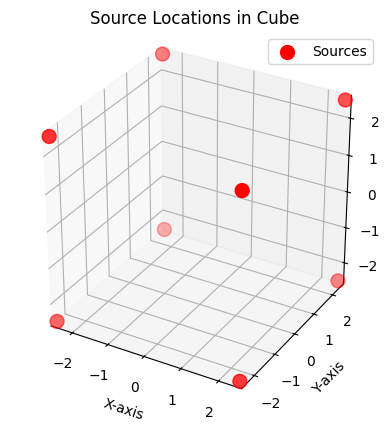

In [2]:
# Extract source coordinates
source_coords = np.array([[loc.x, loc.y, loc.z] for loc in source_locs])

# Plot source locations in 3D
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')

# Plot cube boundaries
ax.set_xlim(-L / 2, L / 2)
ax.set_ylim(-L / 2, L / 2)
ax.set_zlim(-L / 2, L / 2)
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

# Add sources as red markers
ax.scatter(source_coords[:, 0], source_coords[:, 1], source_coords[:, 2],
           color='red', label='Sources', s=100)

# Add labels and legend
ax.set_title('Source Locations in Cube')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

plt.show()

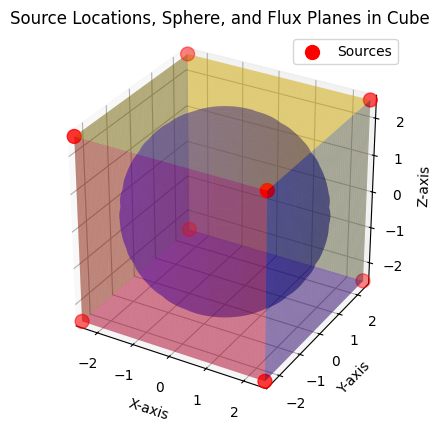

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simulation parameters (from previous code)
L = 5  # Half length of the cube
radius = L / 2  # Radius of the sphere

# Extract source coordinates (from previous code)
source_locs = [
    mp.Vector3(-L / 2, -L / 2, -L / 2), mp.Vector3(L / 2, -L / 2, -L / 2),
    mp.Vector3(-L / 2, L / 2, -L / 2), mp.Vector3(L / 2, L / 2, -L / 2),
    mp.Vector3(-L / 2, -L / 2, L / 2), mp.Vector3(L / 2, -L / 2, L / 2),
    mp.Vector3(-L / 2, L / 2, L / 2), mp.Vector3(L / 2, L / 2, L / 2)
]
source_coords = np.array([[loc.x, loc.y, loc.z] for loc in source_locs])

# Plot source locations in 3D
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')

# Plot cube boundaries
ax.set_xlim(-L / 2, L / 2)
ax.set_ylim(-L / 2, L / 2)
ax.set_zlim(-L / 2, L / 2)
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

# Add sources as red markers
ax.scatter(source_coords[:, 0], source_coords[:, 1], source_coords[:, 2],
           color='red', label='Sources', s=100)

# Add the sphere
phi = np.linspace(0, np.pi, 100)  # Polar angle
theta = np.linspace(0, 2 * np.pi, 100)  # Azimuthal angle
phi, theta = np.meshgrid(phi, theta)

# Parametric equations for the sphere
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)

# Plot the surface of the sphere
ax.plot_surface(x, y, z, color='blue', alpha=0.3, rstride=5, cstride=5)

# Define flux plane locations (from the previous code)
flux_planes = [
    mp.Vector3(-L / 2, 0, 0),  # Left face
    mp.Vector3(L / 2, 0, 0),   # Right face
    mp.Vector3(0, -L / 2, 0),  # Bottom face
    mp.Vector3(0, L / 2, 0),   # Top face
    mp.Vector3(0, 0, -L / 2),  # Back face
    mp.Vector3(0, 0, L / 2)    # Front face
]

# List of colors for flux planes
flux_plane_colors = ['green', 'blue', 'red', 'yellow', 'purple', 'orange']

# Add flux planes as semi-transparent surfaces with different colors
for i, plane in enumerate(flux_planes):
    color = flux_plane_colors[i % len(flux_plane_colors)]  # Cycle through colors

    # Plane parallel to the XY plane
    if plane.z == L / 2 or plane.z == -L / 2:
        X, Y = np.meshgrid(np.linspace(-L / 2, L / 2, 100), np.linspace(-L / 2, L / 2, 100))
        Z = np.full_like(X, plane.z)
        ax.plot_surface(X, Y, Z, color=color, alpha=0.3)

    # Plane parallel to the XZ plane
    elif plane.y == L / 2 or plane.y == -L / 2:
        X, Z = np.meshgrid(np.linspace(-L / 2, L / 2, 100), np.linspace(-L / 2, L / 2, 100))
        Y = np.full_like(X, plane.y)
        ax.plot_surface(X, Y, Z, color=color, alpha=0.3)

    # Plane parallel to the YZ plane
    elif plane.x == L / 2 or plane.x == -L / 2:
        Y, Z = np.meshgrid(np.linspace(-L / 2, L / 2, 100), np.linspace(-L / 2, L / 2, 100))
        X = np.full_like(Y, plane.x)
        ax.plot_surface(X, Y, Z, color=color, alpha=0.3)

# Add labels and legend
ax.set_title('Source Locations, Sphere, and Flux Planes in Cube')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

plt.show()


In [4]:
import numpy as np
import plotly.graph_objects as go

# Simulation parameters (from previous code)
L = 5  # Half length of the cube
radius = L / 2  # Radius of the sphere

# Extract source coordinates (from previous code)
source_locs = [
    [-L / 2, -L / 2, -L / 2], [L / 2, -L / 2, -L / 2],
    [-L / 2, L / 2, -L / 2], [L / 2, L / 2, -L / 2],
    [-L / 2, -L / 2, L / 2], [L / 2, -L / 2, L / 2],
    [-L / 2, L / 2, L / 2], [L / 2, L / 2, L / 2]
]

# Create 3D scatter for sources
source_coords = np.array(source_locs)

# Create figure
fig = go.Figure()

# Plot source locations
fig.add_trace(go.Scatter3d(
    x=source_coords[:, 0], y=source_coords[:, 1], z=source_coords[:, 2],
    mode='markers', marker=dict(color='red', size=5),
    name='Sources'
))

# Create sphere
phi = np.linspace(0, np.pi, 100)  # Polar angle
theta = np.linspace(0, 2 * np.pi, 100)  # Azimuthal angle
phi, theta = np.meshgrid(phi, theta)

x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)

# Plot the surface of the sphere
fig.add_trace(go.Surface(
    x=x, y=y, z=z, colorscale='Blues', opacity=0.3, name='Sphere',
    showscale=False  # Hide color bar
))

# Define flux planes locations (from the previous code)
flux_planes = [
    [-L / 2, 0, 0],  # Left face
    [L / 2, 0, 0],   # Right face
    [0, -L / 2, 0],  # Bottom face
    [0, L / 2, 0],   # Top face
    [0, 0, -L / 2],  # Back face
    [0, 0, L / 2]    # Front face
]

flux_plane_colors = ['green', 'blue', 'red', 'yellow', 'purple', 'orange']

# Add flux planes as semi-transparent surfaces with different colors
for i, plane in enumerate(flux_planes):
    color = flux_plane_colors[i % len(flux_plane_colors)]  # Cycle through colors

    # Plane parallel to the XY plane
    if plane[2] == L / 2 or plane[2] == -L / 2:
        X, Y = np.meshgrid(np.linspace(-L / 2, L / 2, 100), np.linspace(-L / 2, L / 2, 100))
        Z = np.full_like(X, plane[2])
        fig.add_trace(go.Surface(
            x=X, y=Y, z=Z, colorscale=[[0, color], [1, color]], opacity=0.3, name=f'Flux Plane {i+1}',
            showscale=False  # Hide color bar
        ))

    # Plane parallel to the XZ plane
    elif plane[1] == L / 2 or plane[1] == -L / 2:
        X, Z = np.meshgrid(np.linspace(-L / 2, L / 2, 100), np.linspace(-L / 2, L / 2, 100))
        Y = np.full_like(X, plane[1])
        fig.add_trace(go.Surface(
            x=X, y=Y, z=Z, colorscale=[[0, color], [1, color]], opacity=0.3, name=f'Flux Plane {i+1}',
            showscale=False  # Hide color bar
        ))

    # Plane parallel to the YZ plane
    elif plane[0] == L / 2 or plane[0] == -L / 2:
        Y, Z = np.meshgrid(np.linspace(-L / 2, L / 2, 100), np.linspace(-L / 2, L / 2, 100))
        X = np.full_like(Y, plane[0])
        fig.add_trace(go.Surface(
            x=X, y=Y, z=Z, colorscale=[[0, color], [1, color]], opacity=0.3, name=f'Flux Plane {i+1}',
            showscale=False  # Hide color bar
        ))

# Update layout to hide legend
fig.update_layout(
    title='Source Locations, Sphere, and Flux Planes in Cube',
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
        aspectmode='cube'
    ),
    showlegend=False  # Hide legend
)

# Show the figure
fig.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



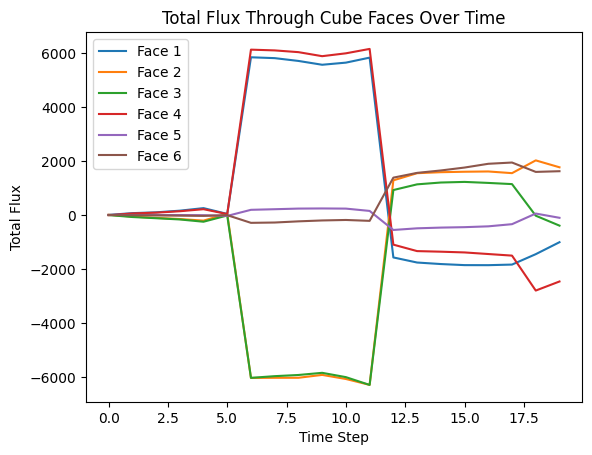

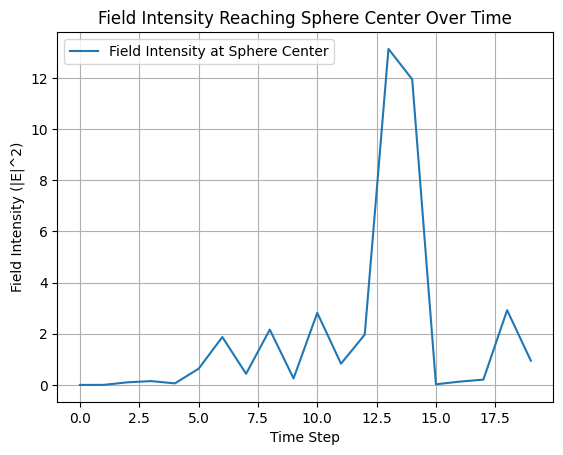

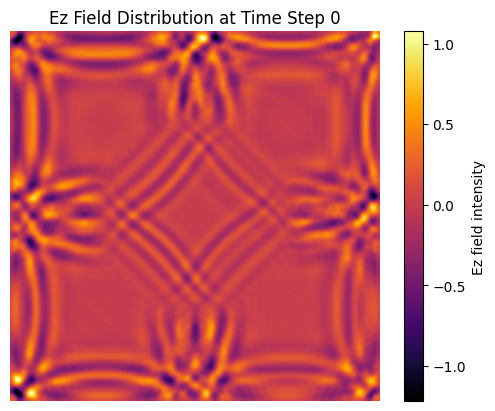

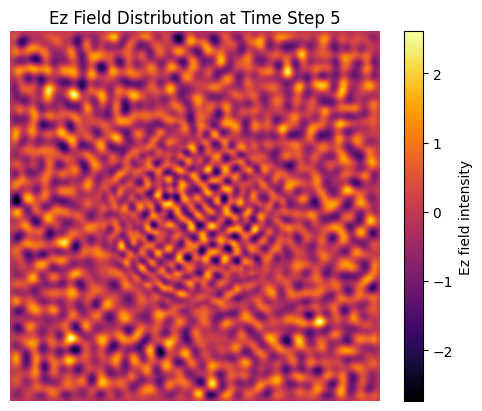

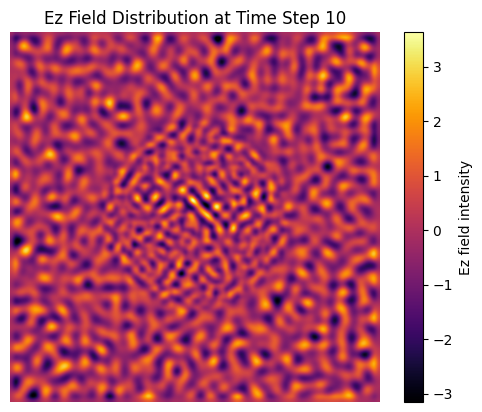

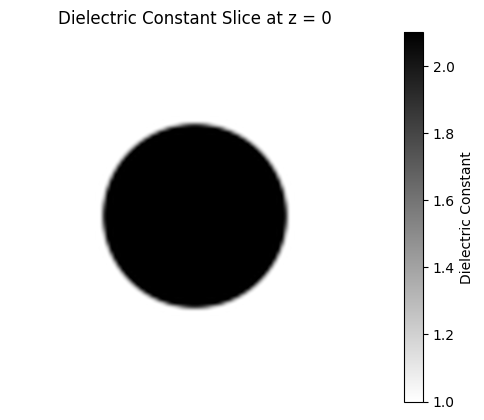

In [6]:
# Visualize the total flux over time for each face
for i, flux_data in flux_storage.items():
    total_flux_over_time = np.array(flux_data)  # Convert to numpy array for easier manipulation
    actual_time_steps = np.arange(len(total_flux_over_time))  # Time steps array
    plt.plot(actual_time_steps, total_flux_over_time, label=f'Face {i + 1}')

plt.xlabel("Time Step")
plt.ylabel("Total Flux")
plt.title("Total Flux Through Cube Faces Over Time")
plt.legend()
plt.show()

# Plot the field intensity over time
plt.figure(dpi=100)
plt.plot(actual_time_steps, field_intensity, label="Field Intensity at Sphere Center")
plt.xlabel("Time Step")
plt.ylabel("Field Intensity (|E|^2)")
plt.title("Field Intensity Reaching Sphere Center Over Time")
plt.legend()
plt.grid(True)
plt.show()




# Convert field data into a numpy array for easier handling
field_data = np.array(field_data)

# Visualize field data at specific time steps
time_indices = [0, 5, 10]

for t in time_indices:
    ez_data = field_data[t]
    z_slice = ez_data.shape[2] // 2  # Take a slice along the z-axis

    plt.figure(dpi=100)
    plt.imshow(ez_data[:, :, z_slice], interpolation='spline36', cmap='inferno')
    plt.colorbar(label='Ez field intensity')
    plt.title(f'Ez Field Distribution at Time Step {t}')
    plt.axis('off')
    plt.show()

# Get the dielectric constant array across the entire simulation domain
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)

# Select a specific slice along the z-axis (the middle slice of the cube)
z_slice = eps_data.shape[2] // 2  # Selecting the middle slice along the z-axis

# Plot the selected slice
plt.figure(dpi=100)
plt.imshow(eps_data[:, :, z_slice].transpose(), interpolation='spline36', cmap='binary')
plt.colorbar(label="Dielectric Constant")
plt.title(f"Dielectric Constant Slice at z = {z_slice - eps_data.shape[2]//2}")
plt.axis('off')
plt.show()

In [ ]:

# Visualize the total flux over time for each face
for i, flux_data in flux_storage.items():
    total_flux_over_time = np.array(flux_data)  # Convert to numpy array for easier manipulation
    actual_time_steps = np.arange(len(total_flux_over_time))  # Time steps array
    plt.plot(actual_time_steps, total_flux_over_time, label=f'Face {i + 1}')

plt.xlabel("Time Step")
plt.ylabel("Total Flux")
plt.title("Total Flux Through Cube Faces Over Time")
plt.legend()
plt.show()

# Plot the field intensity over time
plt.figure(dpi=100)
plt.plot(actual_time_steps, field_intensity, label="Field Intensity at Sphere Center")
plt.xlabel("Time Step")
plt.ylabel("Field Intensity (|E|^2)")
plt.title("Field Intensity Reaching Sphere Center Over Time")
plt.legend()
plt.grid(True)
plt.show()




# Convert field data into a numpy array for easier handling
field_data = np.array(field_data)

# Visualize field data at specific time steps
time_indices = [0, 5, 10]

for t in time_indices:
    ez_data = field_data[t]
    z_slice = ez_data.shape[2] // 2  # Take a slice along the z-axis

    plt.figure(dpi=100)
    plt.imshow(ez_data[:, :, z_slice], interpolation='spline36', cmap='inferno')
    plt.colorbar(label='Ez field intensity')
    plt.title(f'Ez Field Distribution at Time Step {t}')
    plt.axis('off')
    plt.show()

# Get the dielectric constant array across the entire simulation domain
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)

# Select a specific slice along the z-axis (the middle slice of the cube)
z_slice = eps_data.shape[2] // 2  # Selecting the middle slice along the z-axis

# Plot the selected slice
plt.figure(dpi=100)
plt.imshow(eps_data[:, :, z_slice].transpose(), interpolation='spline36', cmap='binary')
plt.colorbar(label="Dielectric Constant")
plt.title(f"Dielectric Constant Slice at z = {z_slice - eps_data.shape[2]//2}")
plt.axis('off')
plt.show()


In [ ]:

# Plot the field intensity over time
plt.figure(dpi=100)
plt.plot(actual_time_steps, field_intensity, label="Field Intensity at Sphere Center")
plt.xlabel("Time Step")
plt.ylabel("Field Intensity (|E|^2)")
plt.title("Field Intensity Reaching Sphere Center Over Time")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'actual_time_steps' is not defined

<Figure size 640x480 with 0 Axes>

-----------
Initializing structure...
time for choose_chunkdivision = 2.00272e-05 s
Working in 3D dimensions.
Computational cell is 10 x 10 x 10 with resolution 10
     sphere, center = (0,0,0)
          radius 2.5
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
subpixel-averaging is 50.2765% done, 3.98489 s remaining
subpixel-averaging is 49.7912% done, 4.05548 s remaining
subpixel-averaging is 50.9559% done, 3.87661 s remaining
time for set_epsilon = 21.8663 s
-----------


FloatProgress(value=0.0, description='0% done ')

Meep progress: 5.300000000000001/100.0 = 5.3% done in 4.0s, 72.0s to go
on time step 106 (time=5.3), 0.0379469 s/step
Meep progress: 11.75/100.0 = 11.8% done in 8.1s, 60.5s to go
on time step 235 (time=11.75), 0.0311688 s/step
Meep progress: 18.1/100.0 = 18.1% done in 12.1s, 54.7s to go
on time step 362 (time=18.1), 0.0317075 s/step
Meep progress: 23.55/100.0 = 23.6% done in 16.1s, 52.2s to go
on time step 471 (time=23.55), 0.0367658 s/step
Meep progress: 30.0/100.0 = 30.0% done in 20.2s, 47.1s to go
on time step 600 (time=30), 0.0316014 s/step
Meep progress: 36.35/100.0 = 36.4% done in 24.2s, 42.3s to go
on time step 728 (time=36.4), 0.0314738 s/step
Meep progress: 41.7/100.0 = 41.7% done in 28.2s, 39.4s to go
on time step 835 (time=41.75), 0.0374197 s/step
Meep progress: 47.0/100.0 = 47.0% done in 32.2s, 36.3s to go
on time step 941 (time=47.05), 0.0378995 s/step
Meep progress: 53.35/100.0 = 53.4% done in 36.2s, 31.7s to go
on time step 1068 (time=53.4), 0.0316252 s/step
Meep progres

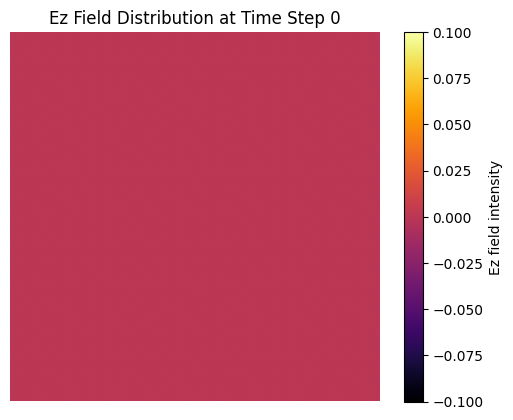

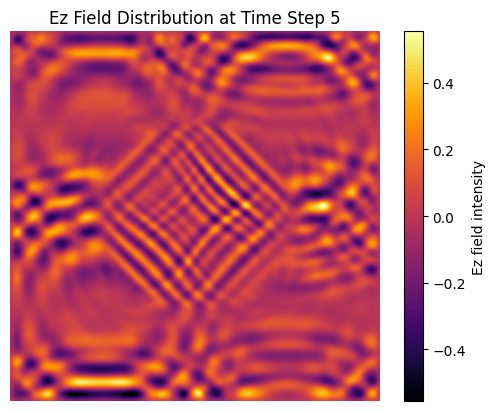

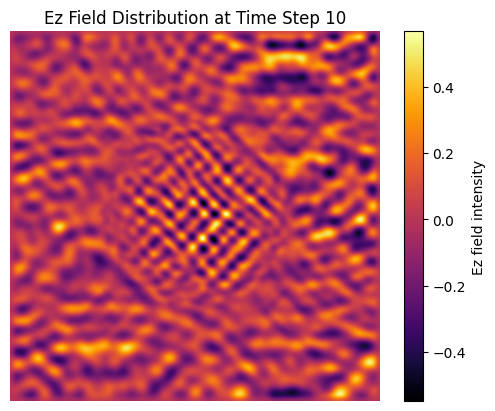

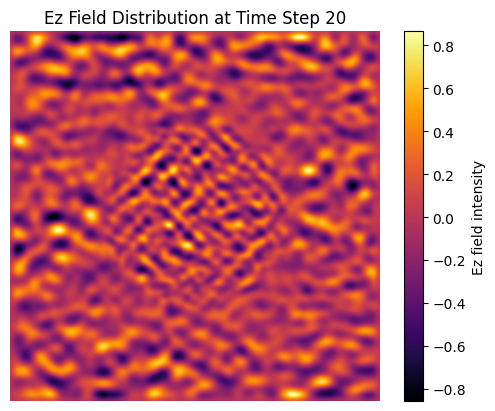

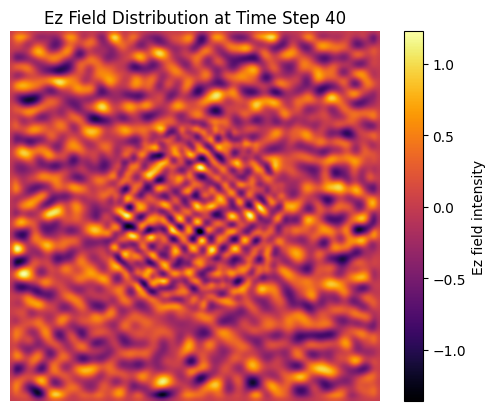

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
resolution = 10
n_r = 1.45  # refractive index of the medium
lambda_min = 0.4
lambda_max = 0.8
f_min = 1 / lambda_max
f_max = 1 / lambda_min
fcen = (f_min + f_max) / 2  # center frequency
df = f_max - f_min  # frequency width
nfreq = 40  # number of frequency points
timesteps = 100  # Number of time steps to collect

# Define the material for the object inside the cube
material = mp.Medium(index=n_r)

# Define the cube cell
LL = 10  # Length of the cube sides
L = LL/2
cell = mp.Vector3(LL, LL, LL)  # Simulation domain size

# Define sources at each corner of the cube with varying frequencies
source_frequencies = [fcen, fcen + df/4, fcen - df/4, fcen + df/8, fcen - df/8, fcen, fcen + df/2, fcen - df/2]
source_locs = [
    mp.Vector3(-L / 2, -L / 2, -L / 2), mp.Vector3(L / 2, -L / 2, -L / 2),
    mp.Vector3(-L / 2, L / 2, -L / 2), mp.Vector3(L / 2, L / 2, -L / 2),
    mp.Vector3(-L / 2, -L / 2, L / 2), mp.Vector3(L / 2, -L / 2, L / 2),
    mp.Vector3(-L / 2, L / 2, L / 2), mp.Vector3(L / 2, L / 2, L / 2)
]

sources = [mp.Source(
    src=mp.ContinuousSource(frequency=freq),
    component=-mp.Ex,
    center=loc
) for freq, loc in zip(source_frequencies, source_locs)]




# Define the geometry (e.g., add a sphere in the center of the cube)
geometry = [mp.Sphere(radius=L / 2, center=mp.Vector3(0, 0, 0), material=material)]

# Create simulation
sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    sources=sources,
    resolution=resolution
)

# Create storage for field data
field_data = []

# Function to collect field data
def collect_field(sim):
    field = sim.get_array(center=mp.Vector3(0, 0, 0), size=cell, component=mp.Ez)
    field_data.append(field)

# Run the simulation and collect field data at every time step
sim.run(mp.at_every(1, collect_field), until=timesteps)

# Convert field data into a numpy array for easier handling
field_data = np.array(field_data)

# Visualize field data at specific time steps
time_indices = [0, 5, 10, 20, 40]

for t in time_indices:
    ez_data = field_data[t]
    z_slice = ez_data.shape[2] // 2  # Take a slice along the z-axis

    plt.figure(dpi=100)
    plt.imshow(ez_data[:, :, z_slice], interpolation='spline36', cmap='inferno')
    plt.colorbar(label='Ez field intensity')
    plt.title(f'Ez Field Distribution at Time Step {t}')
    plt.axis('off')
    plt.show()



In [ ]:
# Get the dielectric constant array across the entire simulation domain
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)

# Select a specific slice along the z-axis (the middle slice of the cube)
z_slice = eps_data.shape[2] // 2  # Selecting the middle slice along the z-axis

# Plot the selected slice
plt.figure(dpi=100)
plt.imshow(eps_data[:, :, z_slice].transpose(), interpolation='spline36', cmap='binary')
plt.colorbar(label="Dielectric Constant")
plt.title(f"Dielectric Constant Slice at z = {z_slice - eps_data.shape[2]//2}")
plt.axis('off')
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 1.90735e-05 s
Working in 3D dimensions.
Computational cell is 10 x 10 x 10 with resolution 10
     sphere, center = (0,0,0)
          radius 2.5
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
subpixel-averaging is 48.2382% done, 4.30985 s remaining
subpixel-averaging is 60.7588% done, 2.60778 s remaining
subpixel-averaging is 50.9559% done, 3.88983 s remaining
subpixel-averaging is 50.0824% done, 4.03156 s remaining
time for set_epsilon = 23.9086 s
-----------


FloatProgress(value=0.0, description='0% done ')

Meep progress: 6.65/100.0 = 6.7% done in 4.0s, 56.5s to go
on time step 133 (time=6.65), 0.0302251 s/step
Meep progress: 13.4/100.0 = 13.4% done in 8.0s, 52.0s to go
on time step 268 (time=13.4), 0.0297434 s/step
Meep progress: 19.450000000000003/100.0 = 19.5% done in 12.1s, 50.0s to go
on time step 389 (time=19.45), 0.0331888 s/step
Meep progress: 26.35/100.0 = 26.4% done in 16.1s, 44.9s to go
on time step 527 (time=26.35), 0.0290266 s/step
Meep progress: 33.25/100.0 = 33.2% done in 20.1s, 40.3s to go
on time step 665 (time=33.25), 0.0290327 s/step
Meep progress: 39.150000000000006/100.0 = 39.2% done in 24.1s, 37.5s to go
on time step 783 (time=39.15), 0.0340178 s/step
Meep progress: 46.050000000000004/100.0 = 46.1% done in 28.1s, 33.0s to go
on time step 921 (time=46.05), 0.0290719 s/step
Meep progress: 53.0/100.0 = 53.0% done in 32.1s, 28.5s to go
on time step 1060 (time=53), 0.0288491 s/step
Meep progress: 58.85/100.0 = 58.9% done in 36.2s, 25.3s to go
on time step 1177 (time=58.85

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


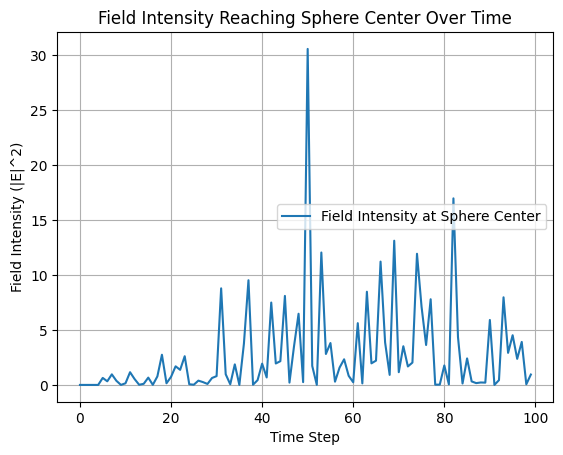

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
resolution = 10
n_r = 1.45  # refractive index of the medium
lambda_min = 0.4
lambda_max = 0.8
f_min = 1 / lambda_max
f_max = 1 / lambda_min
fcen = (f_min + f_max) / 2  # center frequency
df = f_max - f_min  # frequency width
nfreq = 40  # number of frequency points
timesteps = 100  # Number of time steps to collect

# Define the material for the object inside the cube
material = mp.Medium(index=n_r)

# Define the cube cell
LL = 10  # Length of the cube sides
L = LL / 2
cell = mp.Vector3(LL, LL, LL)  # Simulation domain size

# Define sources at each corner of the cube with varying frequencies
source_frequencies = [fcen, fcen + df/4, fcen - df/4, fcen + df/8, fcen - df/8, fcen, fcen + df/2, fcen - df/2]
source_locs = [
    mp.Vector3(-L / 2, -L / 2, -L / 2), mp.Vector3(L / 2, -L / 2, -L / 2),
    mp.Vector3(-L / 2, L / 2, -L / 2), mp.Vector3(L / 2, L / 2, -L / 2),
    mp.Vector3(-L / 2, -L / 2, L / 2), mp.Vector3(L / 2, -L / 2, L / 2),
    mp.Vector3(-L / 2, L / 2, L / 2), mp.Vector3(L / 2, L / 2, L / 2)
]

sources = [mp.Source(
    src=mp.ContinuousSource(frequency=freq),
    component=mp.Ez,
    center=loc
) for freq, loc in zip(source_frequencies, source_locs)]

# Define the geometry (e.g., add a sphere in the center of the cube)
geometry = [mp.Sphere(radius=L / 2, center=mp.Vector3(0, 0, 0), material=material)]

# Create simulation
sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    sources=sources,
    resolution=resolution
)

# Storage for field intensity at the center over time
field_intensity = []

# Function to collect field intensity at the center
def collect_intensity(sim):
    center_field = sim.get_field_point(mp.Ez, mp.Vector3(0, 0, 0))
    field_intensity.append(center_field**2)  # Store |E|^2

# Run the simulation and collect intensity at each time step
sim.run(mp.at_every(1, collect_intensity), until=timesteps)

# Plot the field intensity over time
plt.figure(dpi=100)
plt.plot(range(timesteps), field_intensity, label="Field Intensity at Sphere Center")
plt.xlabel("Time Step")
plt.ylabel("Field Intensity (|E|^2)")
plt.title("Field Intensity Reaching Sphere Center Over Time")
plt.legend()
plt.grid(True)
plt.show()


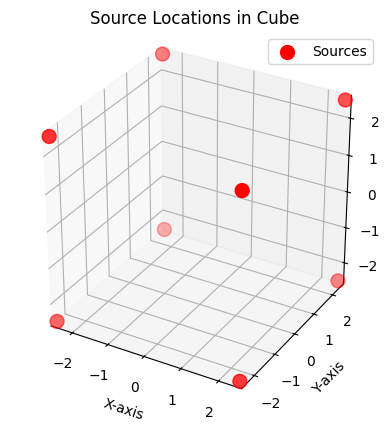

In [ ]:
# Extract source coordinates
source_coords = np.array([[loc.x, loc.y, loc.z] for loc in source_locs])

# Plot source locations in 3D
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')

# Plot cube boundaries
ax.set_xlim(-L / 2, L / 2)
ax.set_ylim(-L / 2, L / 2)
ax.set_zlim(-L / 2, L / 2)
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

# Add sources as red markers
ax.scatter(source_coords[:, 0], source_coords[:, 1], source_coords[:, 2],
           color='red', label='Sources', s=100)

# Add labels and legend
ax.set_title('Source Locations in Cube')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

plt.show()


-----------
Initializing structure...
time for choose_chunkdivision = 0.000396013 s
Working in 3D dimensions.
Computational cell is 10 x 10 x 10 with resolution 10
     sphere, center = (0,0,0)
          radius 2.5
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
subpixel-averaging is 49.8882% done, 4.23773 s remaining
subpixel-averaging is 49.7912% done, 4.03481 s remaining
subpixel-averaging is 48.9176% done, 4.18452 s remaining
subpixel-averaging is 91.8177% done, 0.356505 s remaining
time for set_epsilon = 24.081 s
-----------


FloatProgress(value=0.0, description='0% done ')

Meep progress: 2.2/100.0 = 2.2% done in 4.0s, 178.3s to go
on time step 44 (time=2.2), 0.0910131 s/step
Meep progress: 4.1000000000000005/100.0 = 4.1% done in 8.1s, 188.8s to go
on time step 82 (time=4.1), 0.106645 s/step
Meep progress: 6.45/100.0 = 6.5% done in 12.1s, 175.3s to go
on time step 129 (time=6.45), 0.0852812 s/step
Meep progress: 8.8/100.0 = 8.8% done in 16.1s, 167.2s to go
on time step 176 (time=8.8), 0.0859854 s/step
Meep progress: 10.700000000000001/100.0 = 10.7% done in 20.2s, 168.4s to go
on time step 214 (time=10.7), 0.106446 s/step
Meep progress: 13.0/100.0 = 13.0% done in 24.4s, 163.6s to go
on time step 260 (time=13), 0.092543 s/step
Meep progress: 15.25/100.0 = 15.2% done in 28.5s, 158.3s to go
on time step 305 (time=15.25), 0.0895782 s/step
Meep progress: 17.2/100.0 = 17.2% done in 32.5s, 156.5s to go
on time step 344 (time=17.2), 0.103211 s/step
Meep progress: 19.450000000000003/100.0 = 19.5% done in 36.5s, 151.4s to go
on time step 389 (time=19.45), 0.0897404 

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


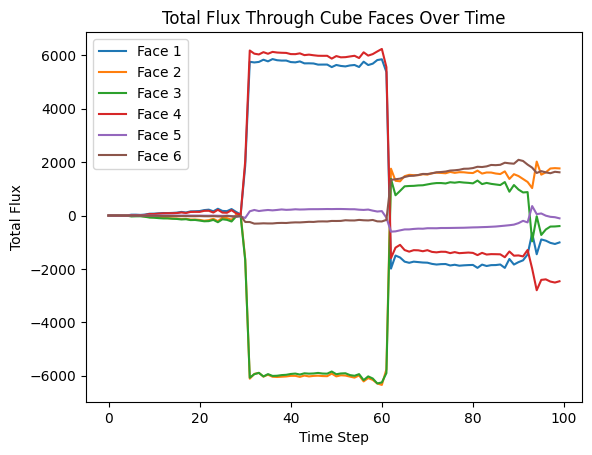

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
resolution = 10
n_r = 1.45  # refractive index of the medium
lambda_min = 0.4
lambda_max = 0.8
f_min = 1 / lambda_max
f_max = 1 / lambda_min
fcen = (f_min + f_max) / 2  # center frequency
df = f_max - f_min  # frequency width
nfreq = 40  # number of frequency points
timesteps = 100  # Number of time steps to collect

# Define the material for the object inside the cube
material = mp.Medium(index=n_r)

# Define the cube cell
LL = 10  # Length of the cube sides
L = LL / 2
cell = mp.Vector3(LL, LL, LL)  # Simulation domain size

# Define sources at each corner of the cube with varying frequencies
source_frequencies = [fcen, fcen + df/4, fcen - df/4, fcen + df/8, fcen - df/8, fcen, fcen + df/2, fcen - df/2]
source_locs = [
    mp.Vector3(-L / 2, -L / 2, -L / 2), mp.Vector3(L / 2, -L / 2, -L / 2),
    mp.Vector3(-L / 2, L / 2, -L / 2), mp.Vector3(L / 2, L / 2, -L / 2),
    mp.Vector3(-L / 2, -L / 2, L / 2), mp.Vector3(L / 2, -L / 2, L / 2),
    mp.Vector3(-L / 2, L / 2, L / 2), mp.Vector3(L / 2, L / 2, L / 2)
]

sources = [mp.Source(
    src=mp.ContinuousSource(frequency=freq),
    component=mp.Ez,
    center=loc
) for freq, loc in zip(source_frequencies, source_locs)]

# Define the geometry (e.g., add a sphere in the center of the cube)
geometry = [mp.Sphere(radius=L / 2, center=mp.Vector3(0, 0, 0), material=material)]

# Create the simulation
sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    sources=sources,
    resolution=resolution
)

# Define FluxRegions on the faces of the cube
flux_planes = [
    mp.FluxRegion(center=mp.Vector3(-L / 2, 0, 0), size=mp.Vector3(0, LL, LL)),  # Left face
    mp.FluxRegion(center=mp.Vector3(L / 2, 0, 0), size=mp.Vector3(0, LL, LL)),   # Right face
    mp.FluxRegion(center=mp.Vector3(0, -L / 2, 0), size=mp.Vector3(LL, 0, LL)),  # Bottom face
    mp.FluxRegion(center=mp.Vector3(0, L / 2, 0), size=mp.Vector3(LL, 0, LL)),   # Top face
    mp.FluxRegion(center=mp.Vector3(0, 0, -L / 2), size=mp.Vector3(LL, LL, 0)),  # Back face
    mp.FluxRegion(center=mp.Vector3(0, 0, L / 2), size=mp.Vector3(LL, LL, 0))    # Front face
]

# Add flux monitors for each plane
flux_monitors = [sim.add_flux(fcen, df, nfreq, plane) for plane in flux_planes]

# Initialize storage for total flux data (only storing summed flux)
flux_storage = {i: [] for i in range(len(flux_planes))}  # Dictionary to store flux data per face

# Function to collect total flux data at each time step (sum over frequencies)
def collect_flux(sim):
    for i, monitor in enumerate(flux_monitors):
        flux_data = sim.get_flux_data(monitor)  # Get flux data for each monitor
        total_flux = np.sum(flux_data)  # Sum flux over all frequencies at this time step
        flux_storage[i].append(total_flux)  # Store summed flux data for each face

# Run the simulation and collect flux data (avoid storing large flux arrays)
sim.run(mp.at_every(1, collect_flux), until=timesteps)

# Visualize the total flux over time for each face
for i, flux_data in flux_storage.items():
    total_flux_over_time = np.array(flux_data)  # Convert to numpy array for easier manipulation
    actual_time_steps = np.arange(len(total_flux_over_time))  # Time steps array
    plt.plot(actual_time_steps, total_flux_over_time, label=f'Face {i + 1}')

plt.xlabel("Time Step")
plt.ylabel("Total Flux")
plt.title("Total Flux Through Cube Faces Over Time")
plt.legend()
plt.show()


In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
resolution = 10
n_r = 1.45  # refractive index of the medium
lambda_min = 0.4
lambda_max = 0.8
f_min = 1 / lambda_max
f_max = 1 / lambda_min
fcen = (f_min + f_max) / 2  # center frequency
df = f_max - f_min  # frequency width
nfreq = 40  # number of frequency points
timesteps = 100  # Number of time steps to collect

# Define the material for the object inside the cube
material = mp.Medium(index=n_r)

# Define the cube cell
LL = 10  # Length of the cube sides
L = LL / 2
cell = mp.Vector3(LL, LL, LL)  # Simulation domain size

# Define sources at each corner of the cube with varying frequencies
source_frequencies = [fcen, fcen + df/4, fcen - df/4, fcen + df/8, fcen - df/8, fcen, fcen + df/2, fcen - df/2]
source_locs = [
    mp.Vector3(-L / 2, -L / 2, -L / 2), mp.Vector3(L / 2, -L / 2, -L / 2),
    mp.Vector3(-L / 2, L / 2, -L / 2), mp.Vector3(L / 2, L / 2, -L / 2),
    mp.Vector3(-L / 2, -L / 2, L / 2), mp.Vector3(L / 2, -L / 2, L / 2),
    mp.Vector3(-L / 2, L / 2, L / 2), mp.Vector3(L / 2, L / 2, L / 2)
]

sources = [mp.Source(
    src=mp.ContinuousSource(frequency=freq),
    component=mp.Ez,
    center=loc
) for freq, loc in zip(source_frequencies, source_locs)]

# Define the geometry (e.g., add a sphere in the center of the cube)
geometry = [mp.Sphere(radius=L / 2, center=mp.Vector3(0, 0, 0), material=material)]

# Create the simulation
sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    sources=sources,
    resolution=resolution
)

# Define FluxRegions on the faces of the cube
flux_planes = [
    mp.FluxRegion(center=mp.Vector3(-L/2, 0, 0), size=mp.Vector3(0, LL, LL)),  # Left face
    mp.FluxRegion(center=mp.Vector3(L/2, 0, 0), size=mp.Vector3(0, LL, LL)),   # Right face
    mp.FluxRegion(center=mp.Vector3(0, -L/2, 0), size=mp.Vector3(LL, 0, LL)),  # Bottom face
    mp.FluxRegion(center=mp.Vector3(0, L/2, 0), size=mp.Vector3(LL, 0, LL)),   # Top face
    mp.FluxRegion(center=mp.Vector3(0, 0, -L/2), size=mp.Vector3(LL, LL, 0)),  # Back face
    mp.FluxRegion(center=mp.Vector3(0, 0, L/2), size=mp.Vector3(LL, LL, 0))    # Front face
]

# Add flux monitors for each plane
flux_monitors = [sim.add_flux(fcen, df, nfreq, plane) for plane in flux_planes]

# Initialize storage for flux data
flux_storage = {i: [] for i in range(len(flux_planes))}  # Use dictionary for storing flux per face

# Function to collect flux data at each time step
def collect_flux(sim):
    for i, monitor in enumerate(flux_monitors):
        flux_data = sim.get_flux_data(monitor)  # Get flux data for each monitor
        flux_storage[i].append(np.sum(flux_data, axis=0))  # Sum over frequencies

# Run the simulation and collect flux data
sim.run(mp.at_every(1, collect_flux), until=timesteps)

# Visualize the total flux over time for each face
for i, flux_data in flux_storage.items():
    total_flux_over_time = np.array(flux_data)  # Convert to numpy array for easier manipulation
    actual_time_steps = np.arange(len(total_flux_over_time))  # Time steps array
    plt.plot(actual_time_steps, total_flux_over_time, label=f'Face {i + 1}')

plt.xlabel("Time Step")
plt.ylabel("Total Flux")
plt.title("Total Flux Through Cube Faces Over Time")
plt.legend()
plt.show()


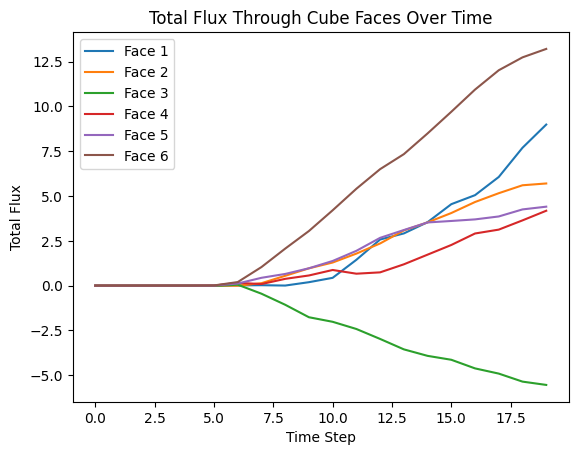

In [ ]:
# Adjust time_steps based on the actual number of steps recorded in flux_storage
for i, flux in enumerate(flux_storage):
    total_flux_over_time = np.sum(flux, axis=1)  # Summing flux over all frequencies for each time step
    actual_time_steps = np.arange(0, len(total_flux_over_time))  # Create time steps array of the correct length
    plt.plot(actual_time_steps, total_flux_over_time, label=f'Face {i + 1}')

plt.xlabel("Time Step")
plt.ylabel("Total Flux")
plt.title("Total Flux Through Cube Faces Over Time")
plt.legend()
plt.show()


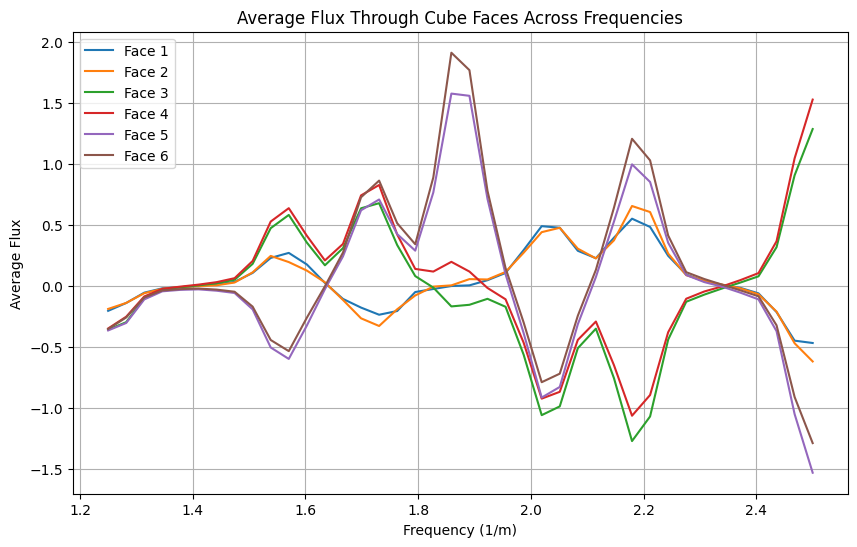

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `flux_storage` contains the flux data for each face
# and that it has been collected over the specified number of time steps.
average_flux_storage = []

for i, flux in enumerate(flux_storage):
    avg_flux = np.mean(flux, axis=0)  # Average over time for each frequency
    average_flux_storage.append(avg_flux)

# Frequency-dependent flux plot (after simulation)
freqs = np.linspace(f_min, f_max, nfreq)  # Create frequency array
plt.figure(figsize=(10, 6))

for i, avg_flux in enumerate(average_flux_storage):
    plt.plot(freqs, avg_flux, label=f'Face {i + 1}')  # Plot average flux for each face

plt.xlabel("Frequency (1/m)")
plt.ylabel("Average Flux")
plt.title("Average Flux Through Cube Faces Across Frequencies")
plt.legend()
plt.grid()
plt.show()


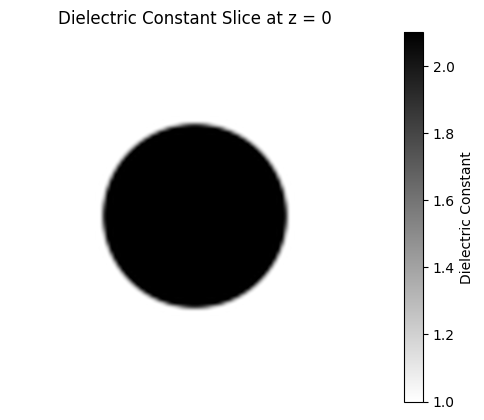